In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model Params
* High Temperature Cooling System
 * HT Cooling System Temperature
   * 05HT
     * Before chare air cooler
     * OUTLET H.T COOLING WATER TEMP
     * Water temperature should be lower than 06HT
   * 06HT
     * After charge air cooler
     * INLET H.T COOLING WATER TEMP
     * Water temperature should be higher than 05HT
 * HT Cooling System Pressure
   * 10HT
     * Water Pressure
     * INLET H.T COOLING WATER TEMP
     * Pressure is lower than temperature

# HT model defining and training
---

In [3]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import drive.MyDrive.scripts.utils as util

from datetime import datetime
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

warnings.filterwarnings('ignore')

## Configuration parameters

In [70]:
''' DATASET
-------------------------------------------------------
'''

# Dataset size
SIZE = 'month' # Alternative: 'day'

# Insert preferred ship and date here
FILE = {
    'ship': '13218',
    'year': '2023',
    'month': '9',
    'day': '4'
}

if (SIZE == 'month'):
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}'
else:
  SHORT = f'{FILE["ship"]}-{FILE["year"]}-{FILE["month"]}-{FILE["day"]}'


# NB: Changing this will alter what attributes the model will be trained to predict
y_attr = ['06HT']

# NB: Changing this will alter what attributes the model will receive as input
x_attr = ['05HT', '87XS', '10HT']

# Prøv x_attr med:
# - ['05HT']                    Check
# - ['05HT', '87XS']            Check
# - ['05HT', '10HT']
# - ['05HT', '87XS', '10HT']



''' MODEL
-------------------------------------------------------
'''

# Model version
VERSION = 'v3'

# Model architecture
ARCHITECTURE = 'LSTM'

# Prediction tag name
TAG_NAME = 'HT'

# Scaler: Active scaler
SCALING_ALGORITHM = 'minmax'
SCALER_PATH       = '/content/drive/MyDrive/scalers/'
SCALER_NAME       = f'{TAG_NAME}-{SCALING_ALGORITHM}-Dataset[{SHORT}]'

# Model: Input and output attributes
X_ATTRIBUTES = x_attr
Y_ATTRIBUTES = y_attr

# Training: Early callback monitors
CALLBACK_LISTENERS = ['loss', 'val_loss']
CALLBACK_PATIENCE  = 5                   # [ 5, 10, 15, 20]

# Model: Compilation
TEST_SIZE_PROPORTION = 0.2
LSTM_LAYER_1_UNITS   = 64
LSTM_LAYER_2_UNITS   = 128
DROPOUT              = 0.25
OPTIMIZER            = 'rmsprop'  # Look into other optimizer functions
LOSS_FUNCTION        = 'mse'

# Training: Epochs and batch size
EPOCHS     = 15                           # [15, 20, 25, 60]
BATCH_SIZE = 64                           # [64, 16, 32, 64]

# Path to model directory
DIR = f'/content/drive/MyDrive/models/{TAG_NAME}/'





''' OTHER
-------------------------------------------------------
'''

# Getting current date
DATE = datetime.today().strftime('%Y-%m-%d')

# Decimal place to round
ROUND = 3

In [71]:
if SIZE == 'month':
  try:
    df = util.open_dataset_at_month(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_month(FILE)
else:
  try:
    df = util.open_dataset_at_date(FILE)
  except:
    !pip install fastparquet
    df = util.open_dataset_at_date(FILE)
df

,B21CA,14LO,24EL,07HT,54XA,55XA,57XA,16DO,15LO,05XS,...,05EX,01EX,06LO,06EX,07EX,08EX,05HT,87XS,missingMsgCount,frequencyMsgCount
time,,,,,,,,,,,,,,,,,,,,,
2023-09-01 00:00:00,0.052,4.572,5.288,71.2,5.0,5.0,5.0,6.826,4.567,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:01,0.052,4.502,5.168,71.2,5.0,5.0,5.0,7.341,4.553,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:02,0.047,4.514,5.240,71.2,5.0,5.0,5.0,7.260,4.510,0.0,...,246.0,218.0,66.0,233.0,225.0,197.0,70.0,0.000000,NaN,NaN
2023-09-01 00:00:03,0.047,4.485,5.216,71.2,5.0,5.0,5.0,7.543,4.416,0.0,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
2023-09-01 00:00:04,0.054,4.485,5.312,71.1,5.0,5.0,5.0,7.899,4.495,0.0,...,245.0,218.0,66.0,233.0,225.0,197.0,69.9,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 23:59:55,0.550,4.372,11.088,79.0,5.0,5.0,5.0,7.138,4.423,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,37.331078,NaN,NaN
2023-09-30 23:59:56,0.538,4.343,11.032,79.0,5.0,5.0,5.0,6.797,4.293,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,36.486485,NaN,NaN
2023-09-30 23:59:57,0.531,4.381,10.968,79.0,5.0,5.0,5.0,7.439,4.416,0.0,...,332.0,335.0,68.0,339.0,332.0,323.0,76.3,35.641890,NaN,NaN


In [72]:
df.fillna(df.mean(), inplace=True)

In [73]:
df, x_attr, y_attr, controlled_parameters = util.produce_modified_dataset(df, x_attr, y_attr)
df

,05HT,10HT,87XS,06HT
time,,,,
2023-09-01 00:00:00,70.0,3.9,0.000000,70.4
2023-09-01 00:00:01,70.0,3.9,0.000000,70.4
2023-09-01 00:00:02,70.0,3.9,0.000000,70.2
2023-09-01 00:00:03,69.9,3.9,0.000000,70.2
2023-09-01 00:00:04,69.9,3.9,0.000000,70.2
...,...,...,...,...
2023-09-30 23:59:55,76.3,3.9,37.331078,78.2
2023-09-30 23:59:56,76.3,3.9,36.486485,78.2
2023-09-30 23:59:57,76.3,3.9,35.641890,78.2


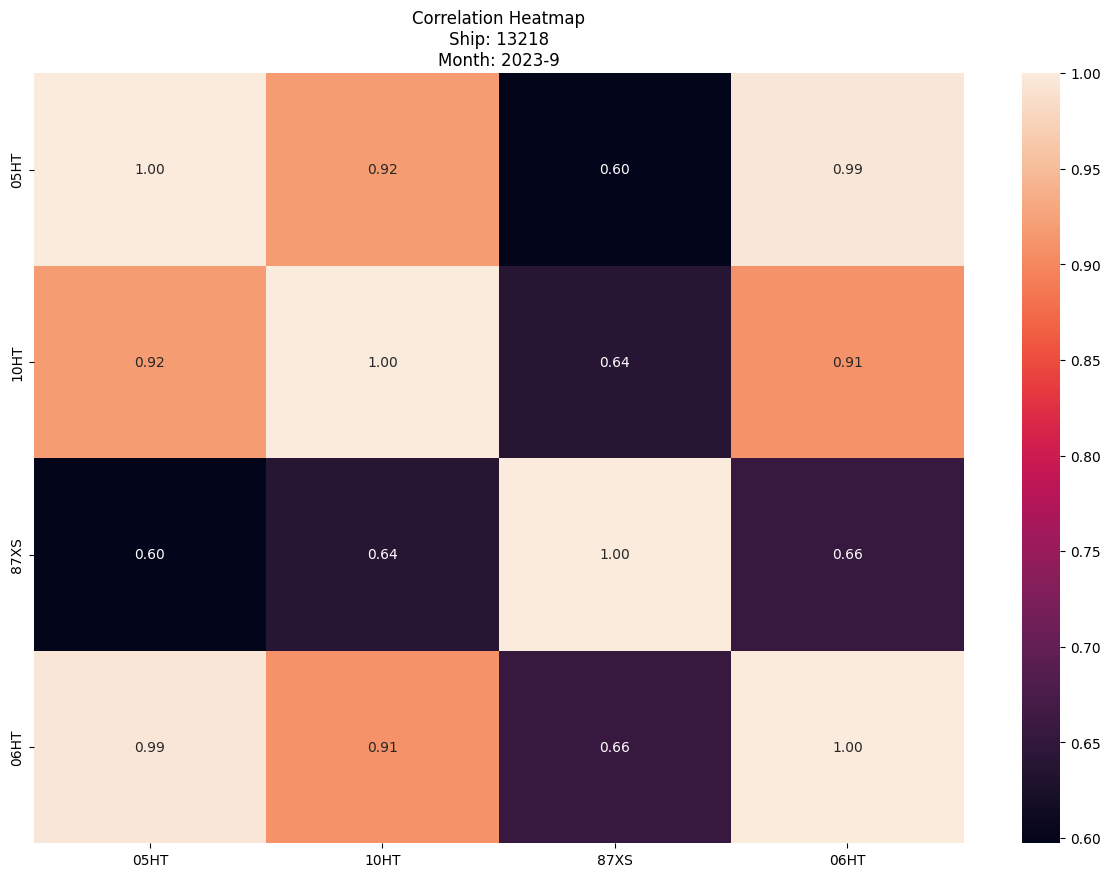

In [74]:
correlation_matrix = df.corr()

title = 'Correlation Heatmap'
ship = f'\nShip: {FILE["ship"]}'

if SIZE == 'month':
  date = f'\nMonth: {FILE["year"]}-{FILE["month"]}'
else:
  date = f'\nDate: {FILE["year"]}-{FILE["month"]}-{FILE["day"]}'

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title(title + ship + date)
plt.show()

Epoch 1/15
28976/28976 [==============================] - 96s 3ms/step - loss: 82.8849 - val_loss: 0.8216
Epoch 2/15
28976/28976 [==============================] - 89s 3ms/step - loss: 9.9576 - val_loss: 0.7555
Epoch 3/15
28976/28976 [==============================] - 91s 3ms/step - loss: 7.1979 - val_loss: 0.9208
Epoch 4/15
28976/28976 [==============================] - 90s 3ms/step - loss: 4.9792 - val_loss: 0.9164
Epoch 5/15
28976/28976 [==============================] - 89s 3ms/step - loss: 3.3064 - val_loss: 0.4901
Epoch 6/15
28976/28976 [==============================] - 89s 3ms/step - loss: 2.0948 - val_loss: 0.3038
Epoch 7/15
28976/28976 [==============================] - 89s 3ms/step - loss: 1.2963 - val_loss: 0.7564
Epoch 8/15
28976/28976 [==============================] - 89s 3ms/step - loss: 0.8211 - val_loss: 0.2870
Epoch 9/15
28976/28976 [==============================] - 89s 3ms/step - loss: 0.5829 - val_loss: 0.3979
Epoch 10/15
28976/28976 [=============================

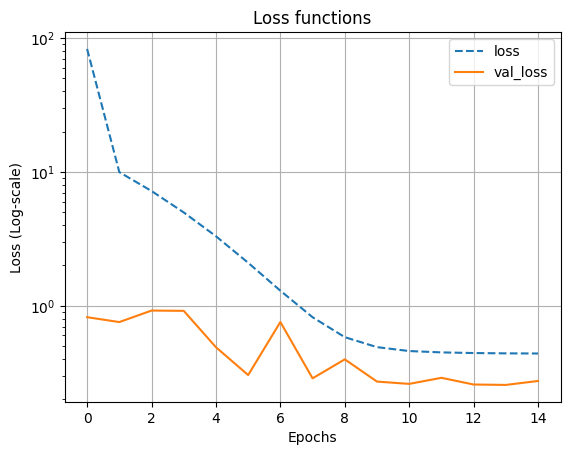

In [75]:
Y_ATTRIBUTES = y_attr

# Setting desired input and output attributes
num_attributes_x = len(X_ATTRIBUTES)
num_attributes_y = len(Y_ATTRIBUTES)
timesteps = 1

dfx = df[X_ATTRIBUTES]
dfy = df[Y_ATTRIBUTES]


# Scaling algorithms
SCALERS = {
    'standard':     StandardScaler().fit(dfx),
    'minmax':       MinMaxScaler(feature_range=(0, 1)).fit(dfx),     # This scaler has given the best results
    'robust':       RobustScaler().fit(dfx),
    'normalizer':   Normalizer().fit(dfx)
}

# Specifying which scaler to use
scaler = SCALERS[ SCALING_ALGORITHM ]        # NB: Scaler must be the same as the one used for training
joblib.dump(scaler, f'{SCALER_PATH}{SCALER_NAME}.joblib')
dfx = pd.DataFrame(scaler.transform(dfx))


X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=TEST_SIZE_PROPORTION, shuffle=False)

X_train = X_train.to_numpy().reshape(X_train.shape[0], timesteps, num_attributes_x)
y_train = y_train.to_numpy().reshape(y_train.shape[0], timesteps, num_attributes_y)

X_test  =  X_test.to_numpy().reshape(X_test.shape[0],  timesteps, num_attributes_x)
y_test  =  y_test.to_numpy().reshape(y_test.shape[0],  timesteps, num_attributes_y)


# Define LSTM model
model = Sequential()
model.add( Bidirectional(LSTM(LSTM_LAYER_1_UNITS, input_shape=(timesteps, num_attributes_x), return_sequences=True)) )
# model.add( Bidirectional(LSTM(LSTM_LAYER_2_UNITS, return_sequences=True)) )
model.add( Dropout(DROPOUT) )
model.add( Dense(num_attributes_y) )


# Compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)


# Adding early stopping listeners for validation metrics
callbacks = []
for listener in CALLBACK_LISTENERS:
  callbacks.append( EarlyStopping(monitor=listener, patience=CALLBACK_PATIENCE, restore_best_weights=True) )


# Training the model
trained_model = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                  validation_data=(X_test, y_test), callbacks=callbacks)


# Plotting the loss as a function of epochs
print('\n')
plt.plot(trained_model.history['loss'],     label='loss', linestyle='dashed')
plt.plot(trained_model.history['val_loss'], label='val_loss')
plt.title('Loss functions')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log-scale)')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [76]:
# Perform predictions
predictions = model.predict(X_test)

# Split the transposed array into 8 separate arrays
print(f'\nDimensions of the array before:\t {predictions.shape}')

# Predictions are on the format (num_observations x timesteps x num_attributes_y)
# We need to convert it to the format (num_attributes_y x num_observations)
predictions = np.transpose(predictions, (2, 1, 0))
predictions = np.array([predictions[i].flatten() for i in range(predictions.shape[0])])

print(f'Dimensions of the array after:\t {predictions.shape}')
print(f'\nPredictions:\n{predictions}')

14488/14488 [==============================] - 23s 2ms/step

Dimensions of the array before:	 (463603, 1, 1)
Dimensions of the array after:	 (1, 463603)

Predictions:
[[77.98422  77.942924 77.922554 ... 77.65382  77.66286  77.75899 ]]


In [77]:
# Preparing the actual values of 01EX, 02EX, ..., 08EX
y_test = np.transpose(y_test, (2, 1, 0))
y_test = np.array([y_test[i].flatten() for i in range(y_test.shape[0])])

print('\tActual\t\tPrediction\tDifference')
print(f'\t{42 * "-"}')

# Printing mean of actual, prediction, and the difference between them
for i in range(num_attributes_y):
  actual  = round(float(y_test[i].mean()), ROUND)
  predict = round(float(predictions[i].mean()), ROUND)
  diff    = round(abs(actual - predict), ROUND)

  print(f'{y_attr[i]}:\t{actual}\t\t{predict}\t\t{diff}')

	Actual		Prediction	Difference
	------------------------------------------
06HT:	78.66		78.507		0.153


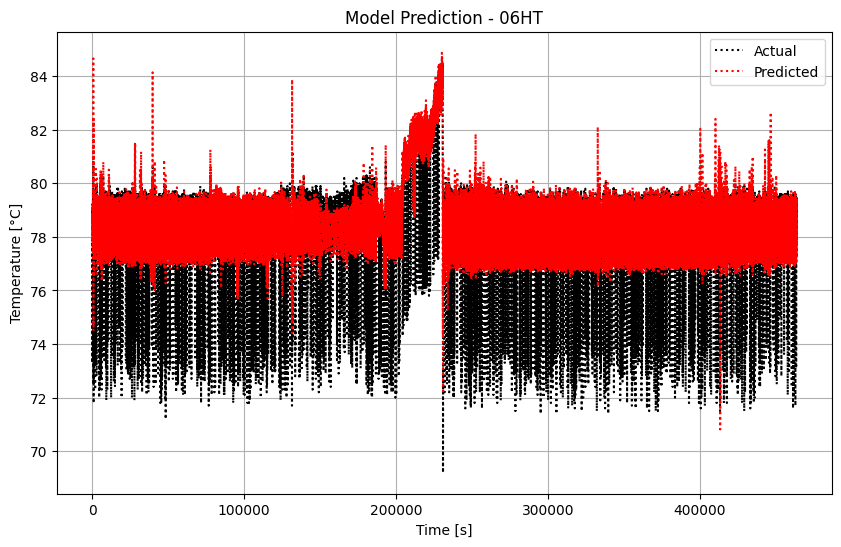


Mean Squared Error: 0.27441984981668294
Root Mean Squared Error: 0.523850980543783
Mean Absolute Error: 0.37267676430966035
R-squared: 0.7844740060109765 




In [78]:
plt.figure(figsize=(10,6))

# Looping through each array of attribute predictions
for i in range(num_attributes_y):

  feature = y_attr[i]

  # Converting attribute predictions and actual values to numpy arrays
  predict = predictions[y_attr.index(feature)]
  actual  = y_test[i]

  # Plotting line graphs for prediction vs. actual
  plt.plot(actual,  label='Actual',    color='black', linestyle=':')
  plt.plot(predict, label='Predicted', color='red',   linestyle=':' )

  plt.xlabel('Time [s]')
  plt.ylabel('Temperature [°C]')
  plt.title(f'Model Prediction - {feature}')

  plt.legend()
  plt.grid()
  plt.show()

  # Calculating quantitative accuracy measures
  mse  = mean_squared_error(actual, predict)
  mae  = mean_absolute_error(actual, predict)
  r2   = r2_score(actual, predict)
  rmse = np.sqrt(mse)

  # Printing quantitative accuracy measures
  print(f'\nMean Squared Error: {mse}')
  print(f'Root Mean Squared Error: {rmse}')
  print(f'Mean Absolute Error: {mae}')
  print(f'R-squared: {r2} \n\n')

In [79]:
trained_model.model.save(f'{DIR}{DATE}-{VERSION}-{ARCHITECTURE}-{TAG_NAME}.h5')